# **Práctica Módulo NLP**
*KeepCoding – Junio 2025*

---
## **1. Objetivo**

Esta práctica tiene como objetivo aplicar los conceptos fundamentales del Procesamiento del Lenguaje Natural (NLP) en un proyecto de análisis de sentimiento supervisado. A través de una serie de ejercicios encadenados, se simulan tareas habituales en proyectos reales de NLP.

Durante el desarrollo se abordarán las principales etapas de un pipeline de NLP clásico, desde la exploración de los datos hasta el preprocesado del texto y el entrenamiento de modelos de clasificación. Se trabajará con un dataset real de reviews de productos de [Amazon](http://jmcauley.ucsd.edu/data/amazon/).


## **1. Descarga y exploración del corpus**

En esta primera parte de la práctica se llevará a cabo la descarga del dataset `reviews_Home_and_Kitchen_5.json.gz` de reseñas de Amazon.

 Se realizará un análisis exploratorio de los datos con el objetivo de obtener la siguiente información:

- Cardinalidad del vocabulario

- Distribución de reviews por número de estrellas

- Número de reviews positivas y negativas

- N-grams más frecuentes

- Nube de palabras

- Visualización en 2 dimensiones de algunos word embeddings calculados con Word2Vec (elegir 4-5 palabras y mostrar sus 10 términos más similares)

- Conclusiones de la exploración

- Cualquier otra métrica, exploración o cálculo adicional que se considere relevante

In [1]:
# Montar Google Drive (solo necesario en Google Colab)
from google.colab import drive
drive.mount('/content/drive')
print("Google Drive montado con éxito.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive montado con éxito.


In [2]:
# Definir directorio de trabajo
WORKING_PATH = '/content/drive/MyDrive/Práctica NLP_Keepcoding'

In [3]:
# Cambiar el directorio de trabajo a la raíz del proyecto
%cd {WORKING_PATH}
!ls

/content/drive/MyDrive/Práctica NLP_Keepcoding
 Dataset			     Modelos	 __pycache__	    Utils.py
'Enunciado Práctica final NLP.pdf'   Notebooks	 requirements.txt


In [4]:
# Importación de librerías
import pandas as pd
import numpy as np
import os
import json
import gzip
import re
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing
import nltk
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk import pos_tag
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from Utils import load_dataset, get_wordnet_pos

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


### 1. Carga del dataset

El archivo `reviews_Home_and_Kitchen_5.json.gz` contiene reseñas de productos de Amazon en formato JSON por líneas.
Se cargan las reviews directamente desde el archivo comprimido utilizando la librería `gzip`.  
Para mayor eficiencia, se utiliza una muestra de 50.000 reseñas.

In [5]:
# Ruta al archivo comprimido en la carpeta 'Dataset'
file_path = os.path.join(WORKING_PATH, 'Dataset', 'reviews_Home_and_Kitchen_5.json.gz')

# Cargar el dataset
df_reviews = load_dataset(file_path, max_reviews=50000)

# Dimensión del dataset
print(df_reviews.shape)

# Mostrar las primeras filas
df_reviews.head()

(50000, 9)


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,APYOBQE6M18AA,0615391206,Martin Schwartz,"[0, 0]",My daughter wanted this book and the price on ...,5.0,Best Price,1382140800,"10 19, 2013"
1,A1JVQTAGHYOL7F,0615391206,Michelle Dinh,"[0, 0]",I bought this zoku quick pop for my daughterr ...,5.0,zoku,1403049600,"06 18, 2014"
2,A3UPYGJKZ0XTU4,0615391206,mirasreviews,"[26, 27]",There is no shortage of pop recipes available ...,4.0,"Excels at Sweet Dessert Pops, but Falls Short ...",1367712000,"05 5, 2013"
3,A2MHCTX43MIMDZ,0615391206,"M. Johnson ""Tea Lover""","[14, 18]",This book is a must have if you get a Zoku (wh...,5.0,Creative Combos,1312416000,"08 4, 2011"
4,AHAI85T5C2DH3,0615391206,PugLover,"[0, 0]",This cookbook is great. I have really enjoyed...,4.0,A must own if you own the Zoku maker...,1402099200,"06 7, 2014"


In [6]:
# Mostrar valores nulos
df_reviews.isnull().sum()

,0
reviewerID,0
asin,0
reviewerName,327
helpful,0
reviewText,0
overall,0
summary,0
unixReviewTime,0
reviewTime,0


In [7]:
# Eliminar valores nulos
df_reviews = df_reviews.dropna().reset_index(drop=True)
df_reviews.isnull().sum()

,0
reviewerID,0
asin,0
reviewerName,0
helpful,0
reviewText,0
overall,0
summary,0
unixReviewTime,0
reviewTime,0


In [8]:
# Selecionamos las columnas relevantes para esta práctica
df_reviews = df_reviews[['reviewText', 'overall', 'summary']]

df_reviews.head()

,reviewText,overall,summary
0,My daughter wanted this book and the price on ...,5.0,Best Price
1,I bought this zoku quick pop for my daughterr ...,5.0,zoku
2,There is no shortage of pop recipes available ...,4.0,"Excels at Sweet Dessert Pops, but Falls Short ..."
3,This book is a must have if you get a Zoku (wh...,5.0,Creative Combos
4,This cookbook is great. I have really enjoyed...,4.0,A must own if you own the Zoku maker...


### 2. Cardinalidad del Vocabulario

Se calcula el número total de palabras únicas presentes en las reviews del dataset con *CountVectorizer*.  

Se eliminan las *stopwords* en inglés para centrarnos en palabras significativas.

In [9]:
# Usamos el reviewText
texts = df_reviews['reviewText']

# Inicializamos el vectorizador con stopwords en inglés
vectorizer = CountVectorizer(stop_words='english')

# Ajustamos el modelo al texto
X = vectorizer.fit_transform(texts)

# Calculamos el número de palabras únicas
vocab_size = len(vectorizer.vocabulary_)
print(f"Cardinalidad del vocabulario: {vocab_size}")

Cardinalidad del vocabulario: 43123


El corpus contiene 43.123 tokens únicos, una vez eliminadas las *stopwords*.

### 3. Distribución de reviews por número de estrellas

overall
1.0     2589
2.0     2157
3.0     3403
4.0     8503
5.0    33021
Name: count, dtype: int64


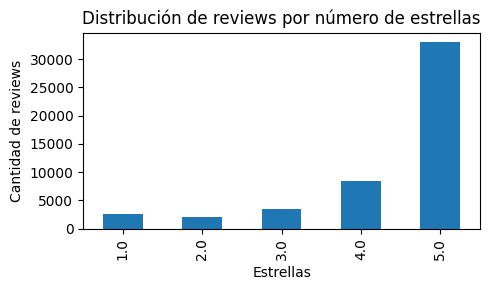

In [10]:
# Conteo de reviews por número de estrellas
star_counts = df_reviews['overall'].value_counts().sort_index()
print(star_counts)

# Visualización
plt.figure(figsize=(5, 3))
star_counts.plot(kind='bar')

plt.title("Distribución de reviews por número de estrellas")
plt.xlabel("Estrellas")
plt.ylabel("Cantidad de reviews")
plt.tight_layout()
plt.show()

Se puede observar una distribución bastante desbalanceada. La mayoría de las reseñas se concentran en 5 estrellas, 33.000 reseñas, mientras que las de 1 y 2 estrellas son significativamente menores.

### 4. Número de reviews positivas y negativas

Analizamos la distribución de sentimientos en el dataset a partir de la puntuación otorgada por los usuarios (overall). Para ello, generamos una etiqueta binaria que clasifica las reviews como positivas o negativas, considerando 1 o 2 estrellas como negativas y 4 o 5 como positivas. Eliminamos las reviews de 3 estrellas que se peden considerar neutras y generar ambigüedad al modelo.

In [11]:
# generamos etiqueta binaria('label'): 1 = positiva (>=4 estrellas), 0 = negativa (<=2 estrellas)
df_reviews = df_reviews[df_reviews['overall'] != 3]  # Eliminamos neutras
df_reviews['label'] = df_reviews['overall'].apply(lambda x: 0 if x >= 4 else 1)

df_reviews.head()

/tmp/ipython-input-11-3311010584.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reviews['label'] = df_reviews['overall'].apply(lambda x: 0 if x >= 4 else 1)


,reviewText,overall,summary,label
0,My daughter wanted this book and the price on ...,5.0,Best Price,0
1,I bought this zoku quick pop for my daughterr ...,5.0,zoku,0
2,There is no shortage of pop recipes available ...,4.0,"Excels at Sweet Dessert Pops, but Falls Short ...",0
3,This book is a must have if you get a Zoku (wh...,5.0,Creative Combos,0
4,This cookbook is great. I have really enjoyed...,4.0,A must own if you own the Zoku maker...,0


Positivas    41524
Negativas     4746
Name: count, dtype: int64


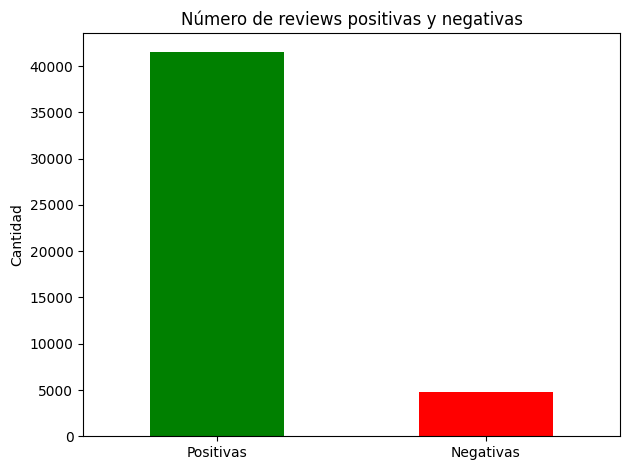

In [12]:
# Visualización distribución de reviews negativas y positivas
sentiment_counts = df_reviews['label'].value_counts().sort_index()
sentiment_counts.index = ['Positivas', 'Negativas']
print(sentiment_counts)

sentiment_counts.plot(kind='bar', color=['green', 'red'])
plt.title('Número de reviews positivas y negativas')
plt.ylabel('Cantidad')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Podemos observar que el dataset presenta un fuerte desbalanceo de clases, con aproximadamente un 90% de reviews positivas frente a solo un 10% de negativas. Esta desproporción puede afectar negativamente al rendimiento del modelo, ya que tenderá a favorecer la clase mayoritaria (positiva), por lo que presentará una alta precisión pero baja capacidad para detectar correctamente las reviews negativas (baja recall para esa clase).

Podríamos usar el parámetro **class_weight='balanced'** durante el entrenamiento del modelo, de tal manera que se ajuste el peso de cada clase en función de su frecuencia y así reducir el sesgo hacia la clase mayoritaria.

A pesar del desequilibrio de clases, el foco principal de este estudio estará en identificar correctamente las opiniones negativas, ya que contienen información valiosa para detectar puntos críticos de insatisfacción y necesidades de mejora.


### 5. N-grams más frecuentes

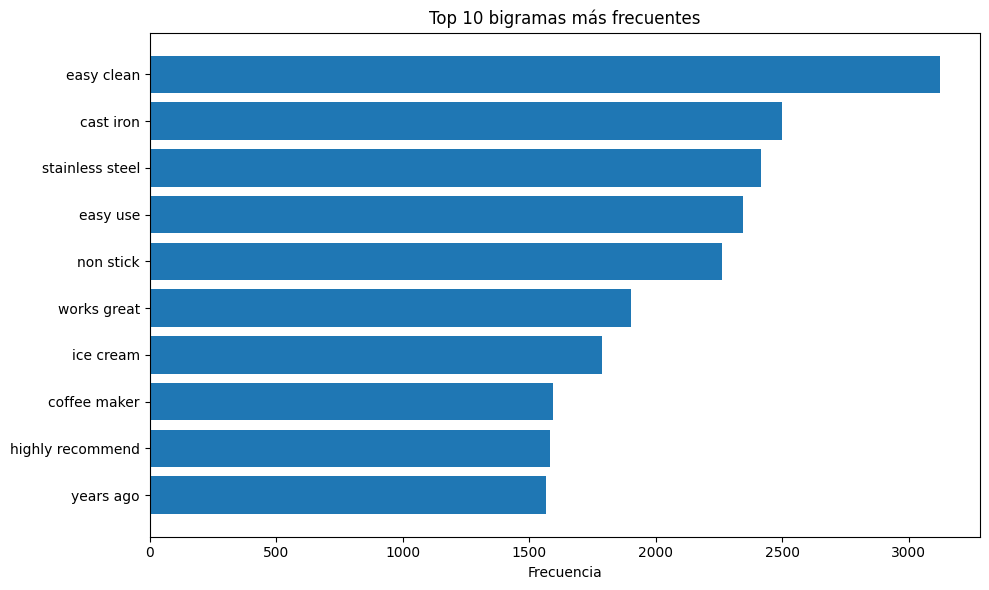

In [13]:
# Determinamos el Top10 de bigramas más frecuentes en el corpus
vectorizer_big = CountVectorizer(ngram_range=(2, 2), stop_words='english', max_features=10)
X_big = vectorizer_big.fit_transform(texts)

bigrams = vectorizer_big.get_feature_names_out()
counts_big = X_big.sum(axis=0).A1    # convierte matriz en array plano

bigram_freq = pd.DataFrame({'bigram': bigrams, 'count': counts_big})
bigram_freq = bigram_freq.sort_values(by='count', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(bigram_freq['bigram'], bigram_freq['count'])
plt.gca().invert_yaxis()
plt.title("Top 10 bigramas más frecuentes")
plt.xlabel("Frecuencia")
plt.tight_layout()
plt.show()

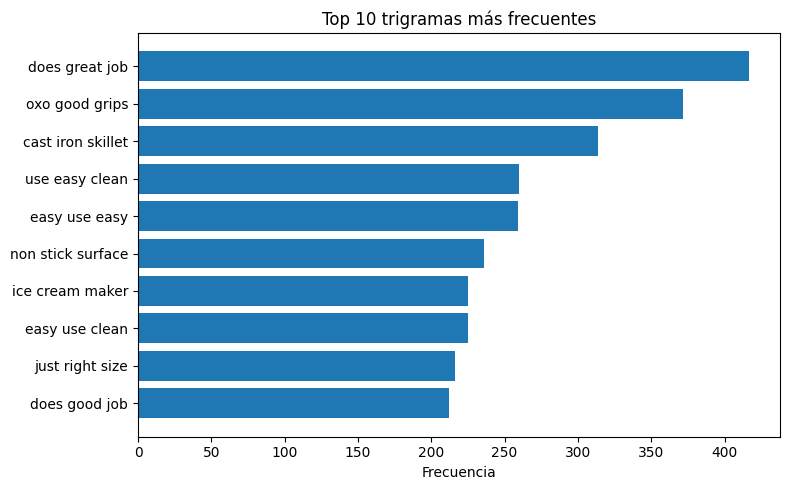

In [14]:
# Determinamos el Top10 de trigramas más frecuentes en el corpus
vectorizer_tri = CountVectorizer(ngram_range=(3, 3), stop_words='english')
X_tri = vectorizer_tri.fit_transform(texts)

trigrams = vectorizer_tri.get_feature_names_out()
counts_tri = X_tri.sum(axis=0).A1    # convierte matriz en array plano

trigram_freq = pd.DataFrame({'trigram': trigrams, 'count': counts_tri})
trigram_freq = trigram_freq.sort_values(by='count', ascending=False).head(10)

plt.figure(figsize=(8, 5))
plt.barh(trigram_freq['trigram'], trigram_freq['count'])
plt.gca().invert_yaxis()
plt.title("Top 10 trigramas más frecuentes")
plt.xlabel("Frecuencia")
plt.tight_layout()
plt.show()

En el análisis de N-grams se observó que las expresiones más frecuentes giran en torno a facilidad de uso ("easy clean", "easy use"), limpieza y satisfacción con respecto al producto ("does great job", "highly recommend"). Tiene sentido, teniendo en cuenta que la gran mayoría de las reviews hemos visto que eran positivas.

En los trigramas podemos ver como algunas expreiones muestran combinaciones redundantes como "easy use easy" o "easy use clean".

Vemos los bigramas más frecuentes según el tipo de review (positiva o negativa).

In [15]:
# Separar reviews positivas y negativas
positivas = df_reviews[df_reviews['label'] == 0]['reviewText']
negativas = df_reviews[df_reviews['label'] == 1]['reviewText']

# Vectorizador y conteo de positivas
vectorizer_pos = CountVectorizer(ngram_range=(2, 2), stop_words='english')
X_pos = vectorizer_pos.fit_transform(positivas)
bigrams_pos = vectorizer_pos.get_feature_names_out()
counts_pos = X_pos.sum(axis=0).A1
df_bigrams_pos = pd.DataFrame({'bigram': bigrams_pos, 'count': counts_pos})
df_bigrams_pos = df_bigrams_pos.sort_values(by='count', ascending=False).head(10)

# Vectorizador y conteo de negativas
vectorizer_neg = CountVectorizer(ngram_range=(2, 2), stop_words='english')
X_neg = vectorizer_neg.fit_transform(negativas)
bigrams_neg = vectorizer_neg.get_feature_names_out()
counts_neg = X_neg.sum(axis=0).A1
df_bigrams_neg = pd.DataFrame({'bigram': bigrams_neg, 'count': counts_neg})
df_bigrams_neg = df_bigrams_neg.sort_values(by='count', ascending=False).head(10)

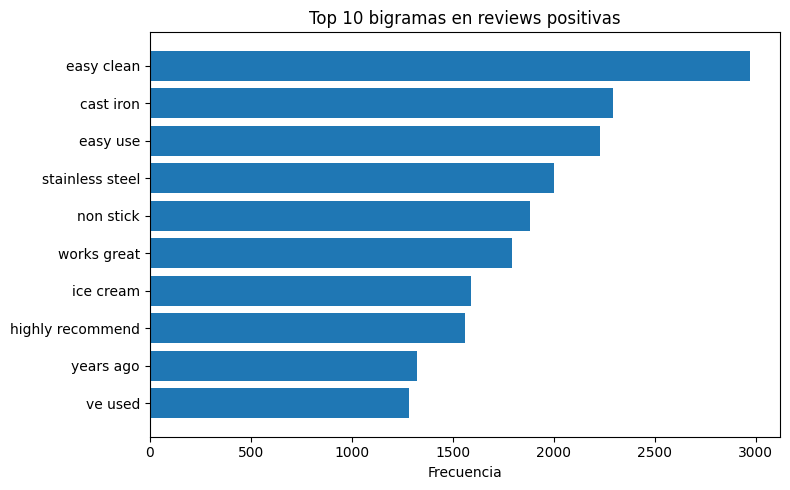

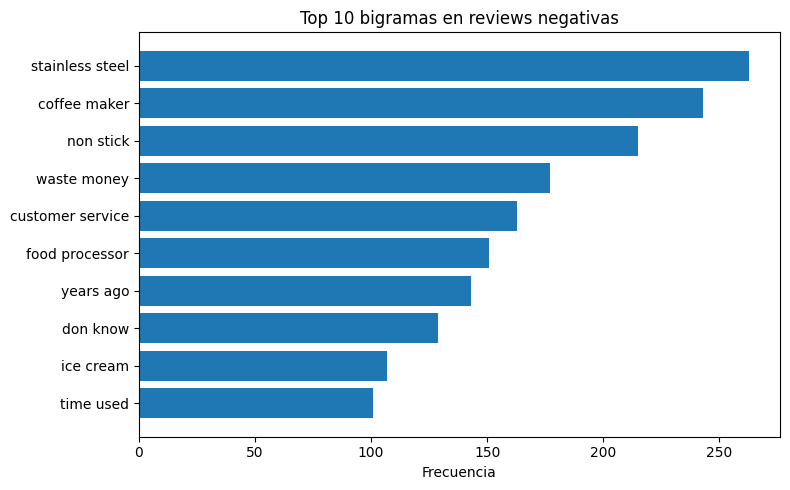

In [16]:
# Visualización Positivas
print()
plt.figure(figsize=(8, 5))
plt.barh(df_bigrams_pos['bigram'], df_bigrams_pos['count'])
plt.gca().invert_yaxis()
plt.title("Top 10 bigramas en reviews positivas")
plt.xlabel("Frecuencia")
plt.tight_layout()
plt.show()

# Visualización Negativas
plt.figure(figsize=(8, 5))
plt.barh(df_bigrams_neg['bigram'], df_bigrams_neg['count'])
plt.gca().invert_yaxis()
plt.title("Top 10 bigramas en reviews negativas")
plt.xlabel("Frecuencia")
plt.tight_layout()
plt.show()

Podemos ver bigramas en las reviews negativas que reflejan claramente la insatisfacción relacionada con el servicio de atención al cliente o con productos que no cumplen las espectativas y sensación de haber malgastado el dinero: "waste money", "customer service", "don know".

También se observa como hay algunos productos concretos que acumulan más reviews negativas, como "coffee maker", "food processor". Se podría tener en cuenta para un análisis más a fondo de qué puede estar fallando con estos productos(funcionalidad, durabilidad, etc.).

La información obtenida de estos n-gramas puede ser muy valiosa para seleccionar las features más adecuadas para modelos basados en **Bag of Words** o **TF-IDF**.

### 6. Word Cloud

In [17]:
# Unir todos los textos y eliminar nulos
text_reviews = " ".join(df_reviews['reviewText'].dropna())

In [18]:
print(text_reviews[:500])

My daughter wanted this book and the price on Amazon was the best.  She has already tried one recipe a day after receiving the book.  She seems happy with it. I bought this zoku quick pop for my daughterr with her zoku quick maker. She loves it and have fun to make her own ice cream. There is no shortage of pop recipes available for free on the web, but I purchased the "Zoku Quick Pops" book, because Zoku has some good recipes for fruit pops on its blog. I was hoping there were more where those 


In [19]:
# Función que construye un wordcloud dado un texto
def plot_word_cloud(text):
  stopwords = STOPWORDS
  wordcloud = WordCloud(max_font_size=50, max_words=50,
    background_color="white", stopwords=stopwords, collocations=True
    ).generate(text)

  plt.figure(figsize=(12, 6))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.tight_layout()
  plt.show()

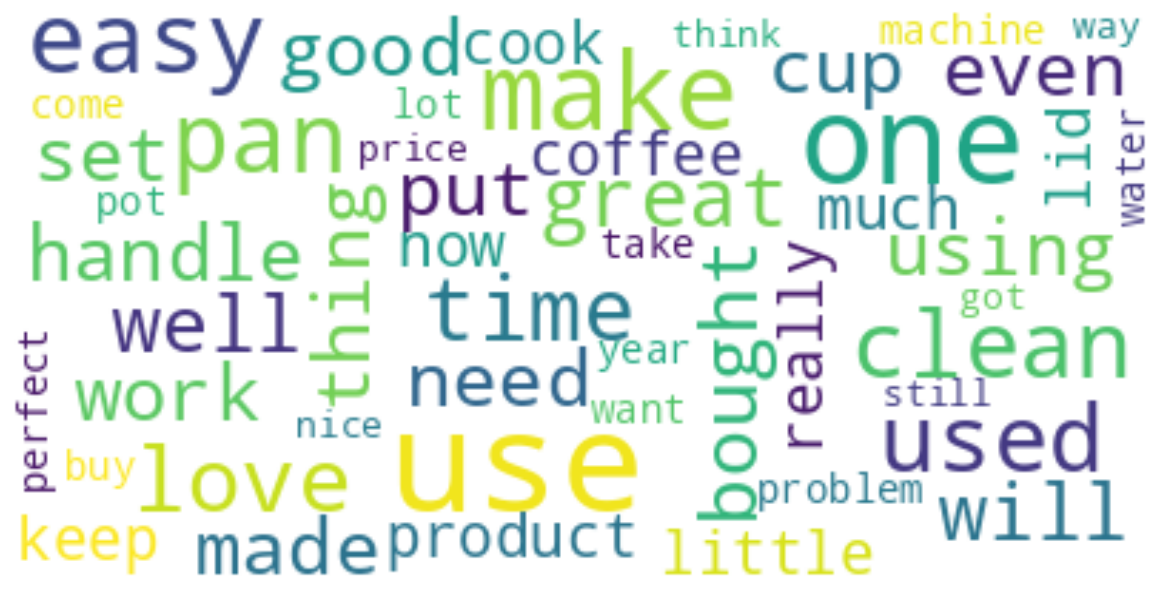

In [20]:
# Texto de reviews positivas
positive_text = " ".join(df_reviews[df_reviews['label'] == 0]['reviewText'])

# Wordcloud para reviews positivas
plot_word_cloud(positive_text)

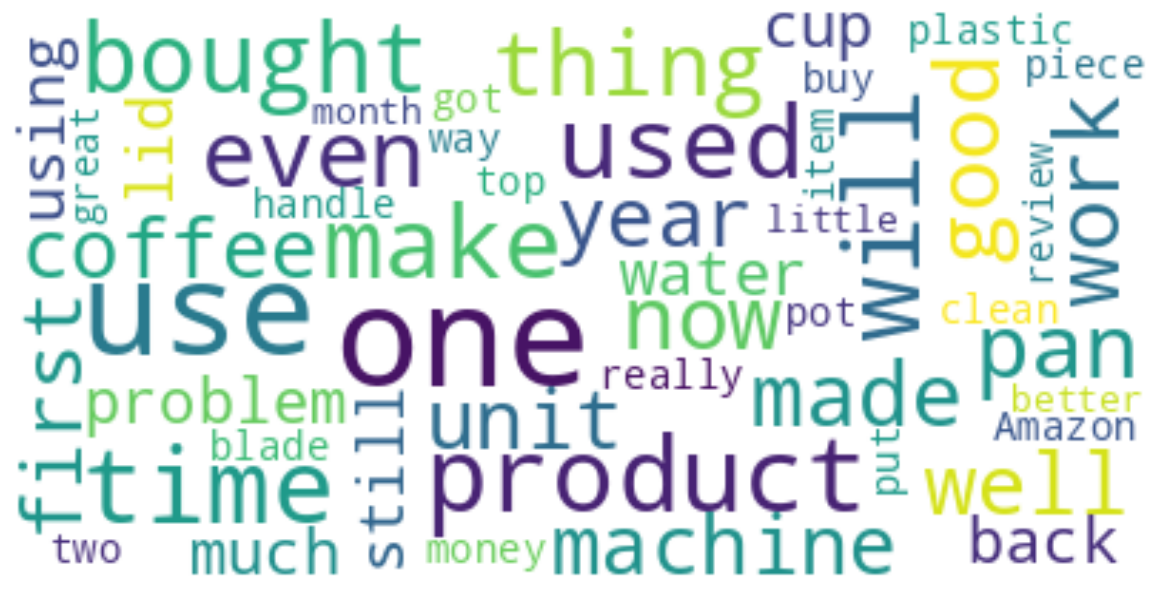

In [21]:
# Texto de reviews negativas
negative_text = " ".join(df_reviews[df_reviews['label'] == 1]['reviewText'])

# Wordcloud para reviews negativas
plot_word_cloud(negative_text)

### 7. Visualización en 2D de Word Embeddings

En este apartado vamos a visualizar en 2 dimensiones algunos word embeddings calculados con Word2Vec (elegimos 4-5 palabras y pintamos las top 10 más similares).

In [22]:
# Preprocesar el texto para entrenar Word2Vec
# Función de limpieza y tokenización
def tokenize_clean(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
    tokens = text.split()
    return [word for word in tokens if len(word) > 2]

# Aplicar al corpus
corpus = [tokenize_clean(text) for text in texts]

In [23]:
# Definimos el número de núcleos disponibles para usar en paralelo
# Esto nos permite acelerar el entrenamiento del modelo Word2Vec
cores = multiprocessing.cpu_count()
print(f"Número de cores disponibles: {cores}")

Número de cores disponibles: 2


Se instancia un modelo Word2Vec usando la biblioteca gensim, configurado con los siguientes hiperparámetros:

- min_count=5: ignora palabras con menos de 5 apariciones.

- window=2: tamaño de ventana de contexto.

- vector_size=100: dimensión de los vectores generados.

- sample=6e-5: submuestreo para palabras muy frecuentes.

- alpha, min_alpha: tasa de aprendizaje inicial y final.

- negative=20: número de muestras negativas.

- workers=cores-1: número de núcleos de CPU utilizados en paralelo.

In [24]:
# Inicializamos el modelo Word2Vec con parámetros personalizados
w2v_model = Word2Vec(
    min_count=5,
    window=2,
    vector_size=100,
    sample=6e-5,
    alpha=0.03,
    min_alpha=0.0007,
    negative=20,
    workers=cores-1
)

A continuación construimos el vocabulario del modelo Word2Vec para entrenar el modelo.

In [25]:
w2v_model.build_vocab(corpus, progress_per=10000)
print('Vocabulario compuesto por {} palabras'.format(len(w2v_model.wv.key_to_index)))

Vocabulario compuesto por 14792 palabras


El modelo Word2Vec ha construido un vocabulario compuesto por 14.792 palabras, a partir de un corpus de 50.000 reviews. Para garantizar que solo se incluyan términos con contexto semántico relevante, se ha aplicado un filtro min_count=5 que descarta palabras con poca frecuencia.

Se entrena el modelo Word2Vec utilizando el corpus previamente tokenizado. El entrenamiento se realiza durante 30 épocas para asegurar una buena convergencia del espacio vectorial.

In [26]:
w2v_model.train(corpus, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(46529832, 114031890)

Durante el entrenamiento, el modelo procesó aproximadamente 46 millones de tokens útiles, frente a los más de 114 millones esperados teóricamente. Esta diferencia se debe al filtrado previo de palabras poco frecuentes (min_count=5). Aun así, el volumen procesado puede ser suficiente.


In [27]:
# Guardamos modelo
w2v_model.save('./Modelos/w2v_model_home&kitchen.pkl')

Probamos nuestro modelo Word2Vec.

In [28]:
w2v_model.wv.most_similar(positive=["clean"])

[('cleanup', 0.7506409287452698),
 ('cleans', 0.6886560320854187),
 ('cleani', 0.6757863759994507),
 ('cleaning', 0.6714184284210205),
 ('easy', 0.6521481275558472),
 ('rinses', 0.626181960105896),
 ('wash', 0.6019130349159241),
 ('cleanit', 0.5760399103164673),
 ('rinse', 0.5735606551170349),
 ('cleanthe', 0.5702365636825562)]

In [29]:
w2v_model.wv.most_similar(positive=["problem"])

[('issue', 0.8571779131889343),
 ('problems', 0.7602701783180237),
 ('issues', 0.680718719959259),
 ('complaint', 0.5631691813468933),
 ('concern', 0.5426521897315979),
 ('trouble', 0.537202775478363),
 ('difficulty', 0.52218097448349),
 ('problemi', 0.5013417601585388),
 ('difficulties', 0.49859046936035156),
 ('complaints', 0.49660027027130127)]

In [30]:
w2v_model.wv.most_similar(positive=["waste"])

[('wasting', 0.6455998420715332),
 ('wasted', 0.6423290967941284),
 ('save', 0.6199396848678589),
 ('saving', 0.6005714535713196),
 ('spend', 0.5285865068435669),
 ('saves', 0.47354376316070557),
 ('plunk', 0.45762795209884644),
 ('saved', 0.4516189396381378),
 ('expend', 0.44795647263526917),
 ('spending', 0.43047764897346497)]

Parece que el modelo ha aprendido bien a relacionar palabras similares en el espacio vectorial.

Probamos ahora con una palabra que no se encuentra en el vocabulario.

In [31]:
'astronaut' in w2v_model.wv.key_to_index

False

In [32]:
w2v_model.wv.most_similar('astronaut')

KeyError: "Key 'astronaut' not present in vocabulary"

No la reconoce y devuelve un error tipo *KeyError*, como era de esperar.

Creamos *clusters* de palabras con las diez más similares a unas dadas.

In [33]:
w2v_model = Word2Vec.load('./Modelos/w2v_model_home&kitchen.pkl')

In [34]:
# Obtener las 10 palabras más similares
keys = ["waste", "work", "time", "problem", "use"]

# Recoger las palabras y sus vectores
embedding_clusters = []
word_clusters = []

for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in w2v_model.wv.most_similar(word, topn=10):
        words.append(similar_word)
        embeddings.append(w2v_model.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

In [35]:
print(word_clusters)

[['wasting', 'wasted', 'save', 'saving', 'spend', 'saves', 'plunk', 'saved', 'expend', 'spending'], ['perform', 'works', 'worked', 'fit', 'bother', 'job', 'working', 'use', 'seem', 'but'], ['timei', 'day', 'timethis', 'once', 'period', 'night', 'hour', 'week', 'morning', 'batch'], ['issue', 'problems', 'issues', 'complaint', 'concern', 'trouble', 'difficulty', 'problemi', 'difficulties', 'complaints'], ['using', 'used', 'need', 'wash', 'clean', 'although', 'and', 'love', 'cook', 'make']]


In [36]:
embedding_clusters[0]

[array([-0.22644633, -1.224713  , -1.0143522 , -0.61017406,  0.7993664 ,
        -0.56561375,  1.210573  ,  1.1545992 ,  0.6856341 , -0.31654894,
        -0.1784905 ,  0.12054673,  1.3869023 ,  1.343573  , -0.6801991 ,
         0.45527342,  0.36826426, -1.4777243 , -0.6031481 ,  1.1223311 ,
         0.8401638 , -0.1848994 , -0.5305727 ,  0.428604  ,  0.5717903 ,
         0.06269023, -0.40558082,  0.09299399, -0.9500867 , -0.1628672 ,
         0.13814981, -0.25256065,  0.28368372,  0.11273168,  0.86874616,
         0.00233816, -0.79269123, -0.9558742 , -0.8385212 , -1.6205202 ,
         0.42069432,  0.91135406,  1.0932277 , -0.5643756 ,  1.0703094 ,
        -0.21456788, -0.00639597, -0.3919939 ,  1.1652772 , -0.6570112 ,
         0.21887048, -0.08839474, -1.2956511 ,  0.76393205,  0.2925042 ,
        -1.4854994 , -0.8619994 ,  0.86631966,  0.12212707, -1.357126  ,
        -1.5708611 , -1.648211  ,  0.17738932,  0.31254685, -1.1230713 ,
         1.4369204 , -0.8309862 , -0.261737  , -0.5

Visualizamos los embeddings reducindo dimensionalidad con TSNE y PCA. Teniendo en cuenta que:

**n**: número de palabras clave (keys). En este caso n = 5.

**m**: número de palabras similares (top 10). En este caso m = 10.

**k**: dimensión de cada embedding. Por defecto suele ser 100.

In [37]:
# Reducir embeddings a 2D con TSNE
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape

# TSNE
tsne_model = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_tsne = tsne_model.fit_transform(embedding_clusters.reshape(n * m, k)).reshape(n, m, 2)

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [38]:
embedding_clusters.shape

(5, 10, 100)

In [39]:
embeddings_tsne.shape

(5, 10, 2)

In [40]:
# Reducción con PCA
pca = PCA(n_components=2, random_state=42)
embeddings_pca = pca.fit_transform(embedding_clusters.reshape(n * m, k)).reshape(n, m, 2)


In [41]:
embeddings_pca.shape

(5, 10, 2)

In [42]:
# Función de visualización de embeddings
def plot_embedding_clusters(labels, embedding_clusters, word_clusters, a=0.7, title=''):
    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import numpy as np

    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=[color], alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.title(title)
    plt.show()

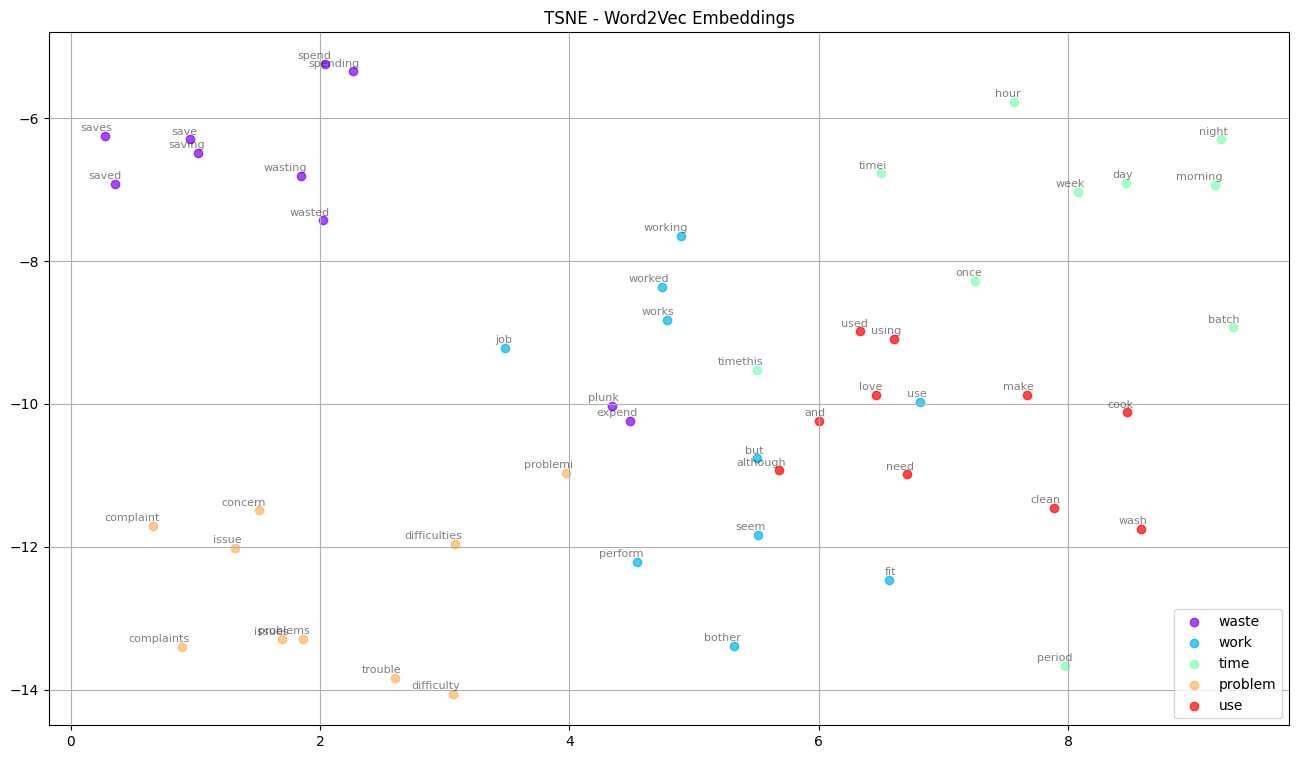

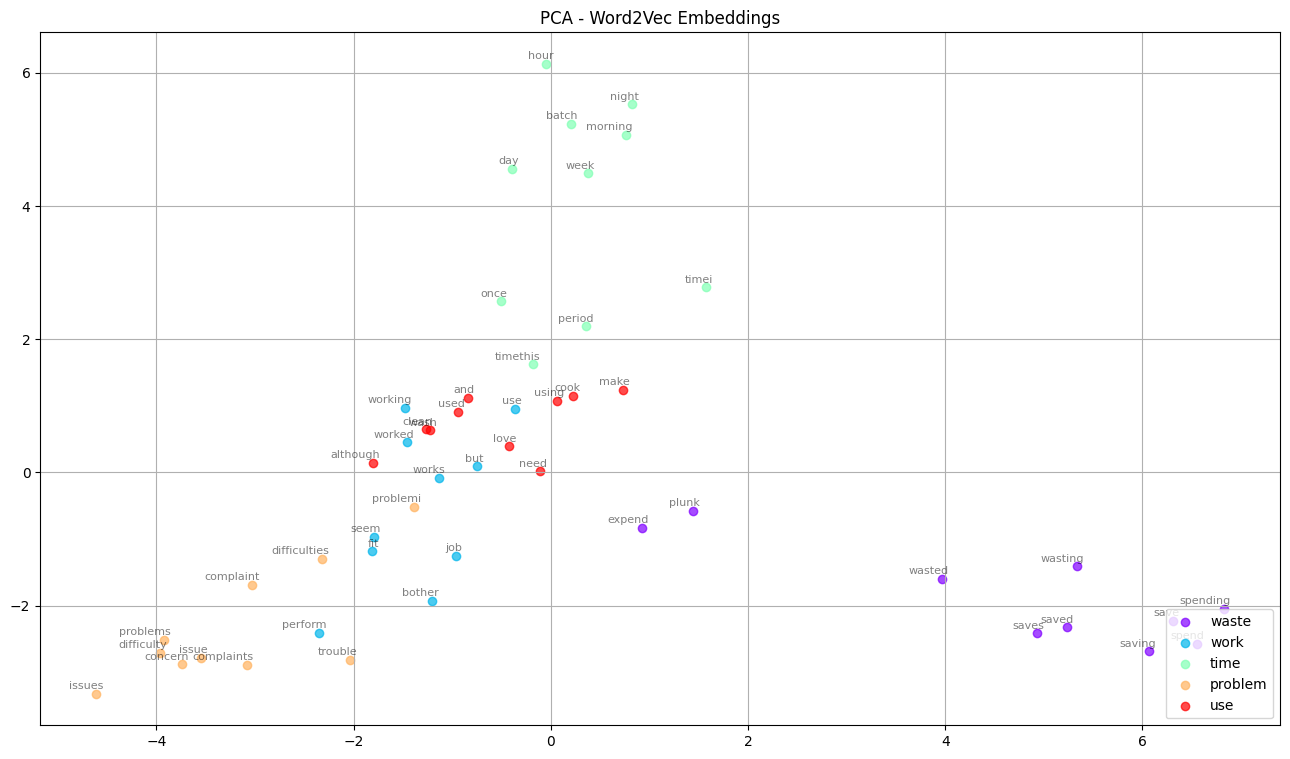

In [43]:
# Visualización con TSNE
plot_embedding_clusters(keys, embeddings_tsne, word_clusters, title='TSNE - Word2Vec Embeddings')

# Visualización con PCA
plot_embedding_clusters(keys, embeddings_pca, word_clusters, title='PCA - Word2Vec Embeddings')

Parece que con TSNE conseguimos separar algo mejor los clusters, esto puede deberse a que captura mejor las relaciones locales y no lineales, y por tanto suele funcionar mejor al visualizar este tipo de datos.


## **3. Preprocesado de Texto**

El objetivo del preprocesado es normalizar y limpiar los textos de las reviews, para facilitar que el modelo de análisis de sentimiento (clasificación binaria) pueda aprender patrones significativos del lenguaje. Este tipo de limpieza mejora la generalización del modelo, reduce la cardinalidad del vocabulario y elimina ruido innecesario.

A continuación creamos una función para el preprocesamiento del texto. Se han tenido en cuenta los siguientes aspectos:

- Conviertir a minúsculas: homogeniza el texto.
- Eliminar puntuación: los signos no aportan valor semántico relevante al análisis de sentimiento en la mayoría de los casos.
- Eliminar espacios al inicio/fin y espacios múltiples: mejora el formato y evita tokens vacíos o duplicados accidentales tras los pasos anteriores
- Eliminar stopwords: limina palabras frecuentes sin valor informativo que podrían añadir ruido.
- Tokenizar: separa el texto en palabras individuales que luego serán procesadas.
- Lematizar según POS tags: la lematización reduce las palabras a su forma base (lemma), utilizando las etiquetas gramaticales (POS tags) para obtener una raíz más precisa.

Usar POS tags mejora la precisión de la lematización.


In [44]:
# Función de preprocesado
def preprocess_data(df, column='reviewText', new_column='review_clean'):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    def clean_text(text):
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        tokens = text.split()
        tokens = [token for token in tokens if token not in stop_words]
        tagged = pos_tag(tokens)
        lemmatized = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in tagged]
        cleaned = " ".join(lemmatized)
        return cleaned if cleaned else None  # evita guardar cadenas vacías

    # Aplicar al DataFrame y eliminar nulos generados
    df[new_column] = df[column].dropna().apply(clean_text)
    df = df.dropna(subset=[new_column]).reset_index(drop=True)
    return df

Para el preprocesado se implementó una función que devuelve el texto limpio y lematizado como una única cadena. Este formato es especialmente adecuado para técnicas clásicas de representación como CountVectorizer o TF-IDF, que requieren entradas en forma de texto plano. Se aplicaron pasos básicos de normalización (minúsculas, eliminación de signos de puntuación, espacios innecesarios), tokenización, eliminación de stopwords y lematización basada en etiquetas gramaticales (POS tags).

In [45]:
# Aplicamos la función de preprocesado al texto
df_reviews = preprocess_data(df_reviews, column='reviewText', new_column='review_clean')
df_reviews.head()

,reviewText,overall,summary,label,review_clean
0,My daughter wanted this book and the price on ...,5.0,Best Price,0,daughter want book price amazon best already t...
1,I bought this zoku quick pop for my daughterr ...,5.0,zoku,0,buy zoku quick pop daughterr zoku quick maker ...
2,There is no shortage of pop recipes available ...,4.0,"Excels at Sweet Dessert Pops, but Falls Short ...",0,shortage pop recipe available free web purchas...
3,This book is a must have if you get a Zoku (wh...,5.0,Creative Combos,0,book must get zoku also highly recommend large...
4,This cookbook is great. I have really enjoyed...,4.0,A must own if you own the Zoku maker...,0,cookbook great really enjoyed review recipe su...


## **4. Entrenamiento y testeo del modelo**

En esta fase del proyecto se entrenarán y evaluarán distintos modelos de clasificación supervisada con el objetivo de predecir el sentimiento de una review (positiva=0 o negativa=1) a partir del texto previamente preprocesado.

Dado que el objetivo principal del proyecto es detectar y comprender mejor las reviews negativas, se pondrá especial atención en esta clase minoritaria. Por ello:

- Se utilizarán métricas centradas en el rendimiento sobre las reviews negativas: recall, precision y F1-score.

- Se aplicarán técnicas de ajuste de pesos de clase (class_weight='balanced') para penalizar los errores en la clase negativa.

### División de los datos en train y test

In [46]:
# Seleccionamos las columnas necesarias del Dataset
sentences = df_reviews['review_clean'].values
labels = df_reviews['label'].values

# Dividimos el dataset en conjunto de entrenamiento y test (80% / 20%)
# Usamos stratify para mantener la proporción original de clases en ambos conjuntos
x_train, x_test, y_train, y_test = train_test_split(
    sentences,
    labels,
    test_size=0.2,
    random_state=42,
    shuffle=True,
    stratify=labels
)

# Mostramos información básica del conjunto
print("Distribución en entrenamiento:", Counter(y_train))
print("Distribución en test:", Counter(y_test))
print("Número de ejemplos de entrenamiento:", len(x_train))
print("Número de etiquetas de entrenamiento:", len(y_train))
print("Ejemplo de texto de entrenamiento:", x_train[0])
print("Número de ejemplos de test:", len(x_test))
print("Número de etiquetas de test:", len(y_test))
print("Ejemplo de texto de test:", x_test[0])

Distribución en entrenamiento: Counter({0: 33211, 1: 3793})
Distribución en test: Counter({0: 8303, 1: 948})
Número de ejemplos de entrenamiento: 37004
Número de etiquetas de entrenamiento: 37004
Ejemplo de texto de entrenamiento: need longer pair tongs grill perfect use quite bit precise control rubberize grip comfortable oxo good grip product usually pretty good exception
Número de ejemplos de test: 9251
Número de etiquetas de test: 9251
Ejemplo de texto de test: good shape strong metal wont bend fit inside spice jar excellent every way


### Entrenamiento Modelo Logistic Regression con Bag of Words

Para el entrenamiento del primer modelo vamos a usar:

- Usremos TF-IDF para generar la matriz de *Bag of Words*:
    - min_df=3: elimina las palabras que aparecen en menos de 3 documentos.
    - max_df=0.9: elimina términos que aparecen en más del 90% de los documento.
    - ngram_range(1,2): se consideran unigramas y bigramas. Los bigramas pueden capturar contexto.
    - max_features=5000: tamaño del vocabulario las 5000 palabras más frecuentes.

- LogisticRegression como modelo clasificador.

- class_weight='balanced' para compensar el desbalance de clases.

Evaluación Logistic Regression + TF-IDF + class_weight='balanced'
              precision    recall  f1-score   support

    Positiva      0.979     0.906     0.941      8303
    Negativa      0.501     0.831     0.625       948

    accuracy                          0.898      9251
   macro avg      0.740     0.868     0.783      9251
weighted avg      0.930     0.898     0.909      9251



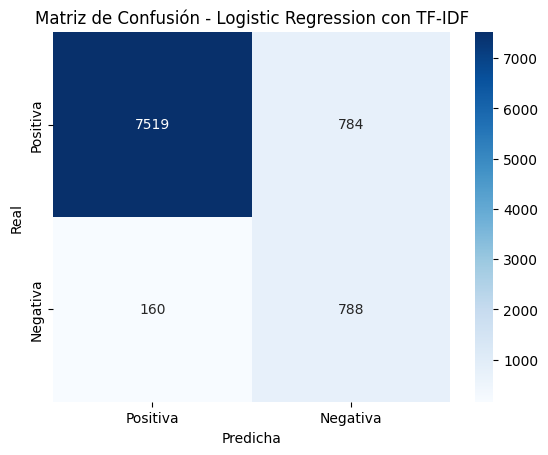

In [53]:
# Definimos el pipeline
pipe_lr = Pipeline([
    ('features_lr', TfidfVectorizer(min_df=3, max_df=0.9, max_features=5000, ngram_range=(1,2))),
    ('model', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
])

# Entrenamiento del modelo
pipe_lr.fit(x_train, y_train)

# Predicciones
y_pred = pipe_lr.predict(x_test)

# Evaluación
print("Evaluación Logistic Regression + TF-IDF + class_weight='balanced'")
print(classification_report(y_test, y_pred, digits=3, target_names=["Positiva", "Negativa"]))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Positiva", "Negativa"], yticklabels=["Positiva", "Negativa"])
plt.xlabel("Predicha")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Logistic Regression con TF-IDF")
plt.show()

El modelo presenta una muy buena precisión en la clase de reviews positivas (0.979), pero muy baja en las reviews negativas (0.501), hay muchos falsos positivos.

Por otra parte el recall es bastante aceptable en la clase de reviews negativas (0.831): detecta 8 de cada 10 reseñas negativas reales. Pero el F1-score podría ser mejorable (0.625), tiene dificultades para clasificar correctamente las reviews negativas.

### Entrenamiento Modelo LinearSVC con TF-IDF

Como segundo enfoque, entrenaremos el siguiente modelo:

- Usaremos de nuevo TF-IDF para generar la matriz de *Bag of Words*, con los mismo parámetros.

- Modelo clasificador: LinearSVC. Se comporta de forma eficiente en espacios de alta dimensión como los generados por representaciones tipo Bag of Words o TF-IDF.

- class_weight='balanced' para compensar el desbalance de clases.

Evaluación LinearSVC + class_weight='balanced'
              precision    recall  f1-score   support

    Positiva      0.974     0.918     0.945      8303
    Negativa      0.522     0.786     0.628       948

    accuracy                          0.904      9251
   macro avg      0.748     0.852     0.786      9251
weighted avg      0.928     0.904     0.913      9251



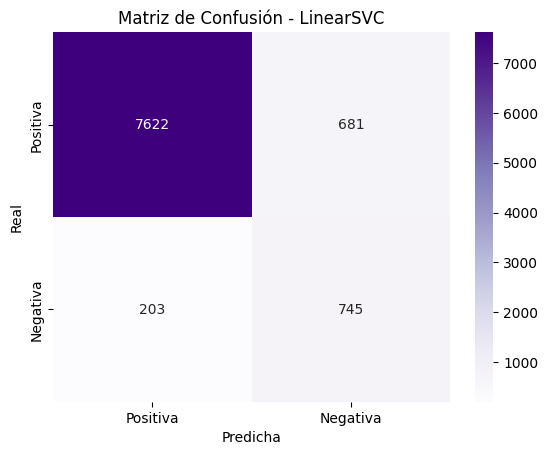

In [54]:
# Definimos el pipeline
pipe_svc = Pipeline([
    ('features_svc', TfidfVectorizer(min_df=3, max_df=0.9, max_features=5000, ngram_range=(1,2))),
    ('model', LinearSVC(class_weight='balanced', max_iter=1000, random_state=42))
])

# Entrenamos el modelo
pipe_svc.fit(x_train, y_train)

# Predicciones
y_pred = pipe_svc.predict(x_test)

# Evaluación
print("Evaluación LinearSVC + class_weight='balanced'")
print(classification_report(y_test, y_pred, digits=3, target_names=["Positiva", "Negativa"]))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", xticklabels=["Positiva", "Negativa"], yticklabels=["Positiva", "Negativa"])
plt.xlabel("Predicha")
plt.ylabel("Real")
plt.title("Matriz de Confusión - LinearSVC")
plt.show()

Con este modelo se ha mejorado algo la precisón (0.522), pero se obtiene un resultado bastante peor en el recall (0.786). El F1-score podemos decir que se mantiene practicamnete igual.

### Entrenamiento Modelo Logistic Regression con Word Embeddings

En este tercer modelo usaremos:

- Representación del texto con embeddings semánticos generados con un modelo Word2Vec.
- Modelo calsificador: LogisticRegression.

Los embedding permiten capturar relaciones semánticas entre las palabras, no solo la frecuencia, por lo que es bastante útil para relaciones de contexto.

Para entrenar el modelo Word2Vec he usado un tamaño de ventana (window=2) bastante pequeño, porque quería que el modelo aprendiera relaciones entre palabras que están muy cerca en el texto.

Con min_count=5 para que no tenga en cuenta palabras que aparecen muy pocas veces, para evitar ruido, vector_size=100 como dimensión de los vectores.

El parámetro sample=6e-5 sirve para que el modelo no se centre tanto en las palabras muy frecuentes, que aparecen mucho pero no ayudan a entender el sentimiento.

Además, he usado negative=20 para aplicar “negative sampling”, que ayuda a entrenar el modelo más rápido y mejor.


Evaluación Word2Vec + Logistic Regression
              precision    recall  f1-score   support

    Positiva      0.978     0.830     0.898      8303
    Negativa      0.360     0.839     0.503       948

    accuracy                          0.831      9251
   macro avg      0.669     0.834     0.701      9251
weighted avg      0.915     0.831     0.857      9251



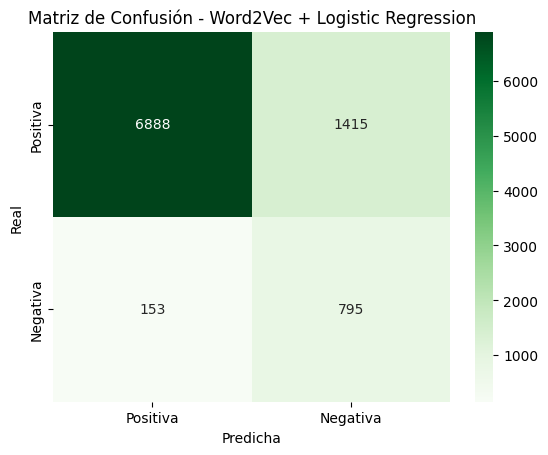

In [51]:
# Tokenización a partir del texto preprocesado y dividido
x_train_tokens = [review.split() for review in x_train]
x_test_tokens = [review.split() for review in x_test]

# Entrenamiento del modelo Word2Vec
w2v_model = Word2Vec(
    sentences=x_train_tokens,
    vector_size=300,
    window=5,
    min_count=5,
    sample=1e-5,
    alpha=0.03,
    min_alpha=0.0007,
    negative=10,
    workers=4
)
w2v_model.train(x_train_tokens, total_examples=w2v_model.corpus_count, epochs=30)

# Guardamos el modelo entrenado
w2v_model.save('./Modelos/w2v_model_cleaned_home&kitchen.pkl')

# Conversión de cada review en un vector promedio
def get_review_vector(tokens):
    vectors = [w2v_model.wv[word] for word in tokens if word in w2v_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(w2v_model.vector_size)

X_train_embed = np.array([get_review_vector(tokens) for tokens in x_train_tokens])
X_test_embed = np.array([get_review_vector(tokens) for tokens in x_test_tokens])

# Entrenamiento del modelo
model_embed = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
model_embed.fit(X_train_embed, y_train)

# Evaluación del modelo
y_pred = model_embed.predict(X_test_embed)

print("Evaluación Word2Vec + Logistic Regression")
print(classification_report(y_test, y_pred, digits=3, target_names=["Positiva", "Negativa"]))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=["Positiva", "Negativa"], yticklabels=["Positiva", "Negativa"])
plt.xlabel("Predicha")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Word2Vec + Logistic Regression")
plt.show()

La clase de reviews positivas tiene muy buen rendimiento: F1-score de 0.898, gracias a una precisión alta (0.978) y un buen recall (0.830).

El recall de la clase de reviews negativas (0.839) es el más alto de todos los modelos hasta ahora, por lo que el modelo detecta muy bien las reseñas negativas, pero en cambio, tiene una preción muy baja (0.360), muchos falsos positivos, así como un F1-score también más bajo (0.503).

Este modelo parece que  captura contexto y sensibilidad, pero no tiene una precisión exacta.

El modelo más fiable, robusto y equilibrado podemos decir que es el de **Logistic Regression + CountVectorizer**.

### Optimización con GridSearchCV

Usaremos GridSearch con cv=5 para optimizar el modelo eligiendo los mejores parámetros. También usaremos TF-IDF.

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Mejores parámetros: {'model__C': 10, 'model__penalty': 'l2', 'vectorizer__max_df': 0.8, 'vectorizer__min_df': 3, 'vectorizer__ngram_range': (1, 3)}

Mejor score (f1_weighted): 0.9348812894671823
Evaluación modelo optimizado
              precision    recall  f1-score   support

    Positiva      0.967     0.964     0.965      8303
    Negativa      0.691     0.714     0.702       948

    accuracy                          0.938      9251
   macro avg      0.829     0.839     0.834      9251
weighted avg      0.939     0.938     0.938      9251



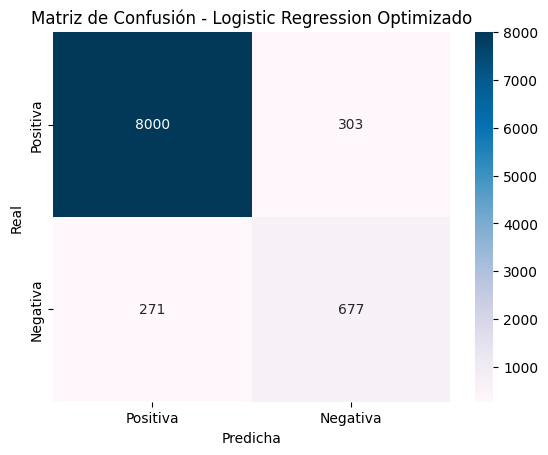

In [55]:
# Definimos el pipeline
pipe = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('model', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
])

# Definimos el grid de hiperparámetros
param_grid = {
    'vectorizer__min_df': [3, 5],
    'vectorizer__max_df': [0.8, 0.9],
    'vectorizer__ngram_range': [(1,1), (1,2), (1,3)],
    'model__C': [0.1, 1, 10],  # Regularización inversa
    'model__penalty': ['l2'], # penalización por defecto
}

# Aplicamos GridSearchCV
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='f1_weighted', verbose=2, n_jobs=-1)
grid_search.fit(x_train, y_train)

# Resultados
print("Mejores parámetros:", grid_search.best_params_)
print("\nMejor score (f1_weighted):", grid_search.best_score_)

# Evaluación en test
best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test)

print("Evaluación modelo optimizado")
print(classification_report(y_test, y_pred, digits=3, target_names=["Positiva", "Negativa"]))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="PuBu", xticklabels=["Positiva", "Negativa"], yticklabels=["Positiva", "Negativa"])
plt.xlabel("Predicha")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Logistic Regression Optimizado")
plt.show()

## **5. Reporte de métricas y conclusiones**

Tras evaluar varios modelos, se seleccionó la versión optimizada de LogisticRegression como modelo final. Aunque el recall de la clase de reseñas negativas fue algo inferior al alcanzado por el modelo sin optimizar, se priorizó un mejor equilibrio entre precisión y recall, lo que se reflejó en un F1-score superior para dicha clase (0.702). Esta elección responde a la necesidad de detectar reseñas negativas con mayor fiabilidad, reduciendo el número de falsos positivos sin sacrificar excesivamente la sensibilidad.

Se empleó como métrica principal el F1-score de la clase negativa, por ser la que mejor refleja este equilibrio en un contexto con clases desbalanceadas y un interés especial en detectar señales de insatisfacción del cliente.

A partir del modelo seleccionado, se llevó a cabo la evaluación sobre el conjunto de test, obteniéndose las siguientes métricas:

| Clase         | Precision | Recall | F1-score | Soporte |
|---------------|-----------|--------|----------|---------|
| **Positiva**  | 0.967     | 0.964  | 0.965    | 8303    |
| **Negativa**  | 0.691     | 0.714  | 0.702    | 948     |
|               |           |        |          |         |
| **Accuracy**  |           |        | **0.938**|         |
| **Macro avg** | 0.829     | 0.839  | **0.834**|         |
| **Weighted avg** | 0.939 | 0.938  | 0.938    |         |


El modelo alcanza una precisión global muy alta (93.8%) y mantiene un rendimiento equilibrado entre ambas clases, lo que se evidencia en el macro F1-score de 0.834. Esta métrica, que promedia el rendimiento por clase sin tener en cuenta el desbalance de datos, confirma que el modelo trata con éxito tanto las reseñas positivas como las negativas.

Aunque el recall negativo (0.714) es menor que el de versiones anteriores, el incremento en la precisión (hasta 0.691) hace que el modelo reduzca significativamente los falsos positivos, mejorando así la confiabilidad del sistema a la hora de identificar reseñas negativas.

Se puede conlcuir que el modelo optimizado proporciona un rendimiento equilibrado y robusto para el análisis de sentimiento. La introducción de n-gramas y la optimización conjunta del vectorizador y del clasificador han sido claves para mejorar la capacidad del modelo para capturar expresiones relevantes del texto. El uso de técnicas como la ponderación de clases (class_weight='balanced') ha sido importante también para mejorar el tratamiento de la clase minoritaria.

Se concluye que este modelo ofrece una solución eficaz y fiable para detectar insatisfacción en reseñas de productos, cumpliendo con el objetivo principal del análisis.